In [9]:
import numpy as np
import jax
import jax.numpy as jnp
import scipy.stats as ss
import tensorly as tl
from tensorly.regression.tucker_regression import TuckerRegressor
from jax import grad
from references.SABR_Free import sabrMC
import time
import matplotlib.pyplot as plt


try:
    tl.set_backend('jax')
except:
    pass
tl.set_backend('jax')

In [4]:
def put_price(P0_K = 1., r=0.0, paths = 1000, steps=100, K=1.0, maturity = 1.0, data=None, seed=1):

    if data is not None:
        S = data.T
    else:
        np.random.seed(seed)
        start = time.time()
        S = sabrMC(F0 = P0_K * K, N=paths, T=steps, n_years=maturity).T
#         print(jnp.mean(S[:,-1]))
        end = time.time()
        print(f'path generation time: {end - start}')
    
    start = time.time()
    dt = maturity/(steps-1)         # time interval
    df = jnp.exp(-r * dt)           # discount factor per time interval
    
    H = jnp.maximum(K - S, 0)           # intrinsic values for put option
    V = jnp.zeros(H.shape)               # value matrix
    V = V.at[:,-1].set(H[:,-1]) 

    # Valuation by LS Method
    for t in range(steps-2, 0, -1):

        good_paths = np.array(H[:,t] > 0)        # paths where the intrinsic value is positive 
                                                 # the regression is performed only on these paths 

        # Valuation by Tucker Regression
        X = S[good_paths, t].reshape((-1,1,1)) # reshape to fill up dimensions
        y = V[good_paths, t+1] * df
        estimator = TuckerRegressor(weight_ranks=[1]*X.ndim, verbose=False, random_state=seed) # hyperparameter: reg_W (default: 1) 
        estimator.fit(X, y)
        fitted_values = estimator.predict(X) # predicted value of option (discounted, as `y` is discounted)

        exercise = jnp.zeros(len(good_paths)).astype(bool) # initialize
        # early exercise when value of early exericse at t > predicted value at t+1 (discounted to t)
        exerise = exercise.at[good_paths].set(H[good_paths,t] > fitted_values)

        V = V.at[exercise,t].set(H[exercise,t]) # set V equal to H where it is optimal to exercise 
        V = V.at[exercise,t+1:].set(0) # set future cash flows, for that path, equal to zero  
        discount_path = V[:,t] == 0 # paths where we didn't exercise
        V = V.at[discount_path,t].set(V[discount_path,t+1] * df) # set V[t] in continuation region

    V0 = jnp.mean(V[:,1]) * df  # discounted expectation of V[t=1]
    end = time.time()
    print(f'longstaff schwartz time: {end-start}')
    return V0

# print("normalize Example price= ", put_price(data=sample.T)) # should be US: 0.0797; EU: 0.0747; 0.07313426907833502
print("Example price= ", put_price(data=None)) # should be 0.0797; 0.07312965550779679

path generation time: 65.53632998466492
longstaff schwartz time: 14.500699758529663
Example price=  0.09796771750586232


In [26]:
print("Example price= ", put_price(data=None, paths=100)) # should be 0.0797; 0.07312965550779679

path generation time: 6.885144233703613
longstaff schwartz time: 2.600893974304199
Example price=  0.11175764655966014


In [27]:
sample = np.genfromtxt('references/sample.csv', delimiter=',')
# check distribution
print(sample.shape) # paths, time
# print(S[:,-1][:5])

print(np.mean(sample.T[:,-1]))
print(np.std(sample.T[:,-1]))
print("Example price= ", put_price(data=sample.T, paths=1000)) # should be 0.0797; 0.07312965550779679

(100, 1000)
1.035333937495947
0.3205740655011473


TypeError: reshape new_sizes must all be positive, got (0, 1, -1).

In [20]:
print('delta:')
delta = grad(put_price, argnums=0)
print(delta(1., 0.0, paths = 100, steps=100, K=1.0, maturity = 1.0, data=None))
# print('gamma:')
# gamma = grad(delta, argnums=0)
# print(gamma(1., 0.0, paths = 100, steps=100, K=1.0, maturity = 1.0, data=None))

delta:
path generation time: 95.25535607337952
longstaff schwartz time: 11.33862590789795
-0.43835102006260507


path generation time: 139.66081190109253
longstaff schwartz time: 56.892704010009766
path generation time: 756.2833759784698
longstaff schwartz time: 85.50923895835876
path generation time: 123.98837399482727
longstaff schwartz time: 85.34698700904846
path generation time: 122.88882994651794
longstaff schwartz time: 67.20772504806519
path generation time: 139.18436288833618
longstaff schwartz time: 30.689214944839478


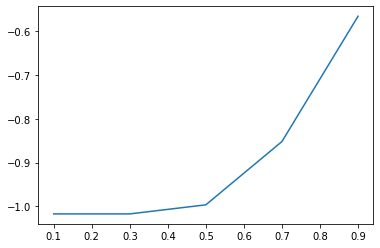

In [14]:
xi = jnp.linspace(0.1,0.9, num=5)
yi = [delta(x, 0.0, paths = 100, steps=100, K=1.0, maturity = 1.0, data=None) for x in xi]

plt.plot(xi,yi)

In [23]:
data = sabrMC(F0 = 1., N=100, T=100, n_years=1)
print(np.mean(data[:,-1]))

0.9572833279215456


In [24]:
print(type(data))

<class 'jaxlib.xla_extension.DeviceArray'>


In [25]:
print('delta:')
delta = grad(put_price, argnums=0)
print(delta(1., 0.0, paths = 100, steps=100, K=1.0, maturity = 1.0, data=data))
print('gamma:')
print(grad(delta)(1., 0.0, paths = 100, steps=100, K=1.0, maturity = 1.0, data=data))


delta:
longstaff schwartz time: 3.712476968765259
0.0
gamma:
longstaff schwartz time: 2.329119920730591
0.0
